In [1]:
import jax.numpy as np
import jax.ops
from jax import grad, jit, vmap
from functools import partial

In [37]:
data = np.load('data/HOOH.DFT.PBE-TS.light.MD.500K.50k.R_E_F_D_Q.npz')
X = np.array(data['R'][:1000])
y = np.array(data['D'][:1000])

In [3]:
def fill_diagonal(a, value):
    return jax.ops.index_update(a, np.diag_indices(a.shape[0]), value)

@jit
def descriptor(x):
    distances = np.sum((x[:, None] - x[None, :])**2, axis=-1)
    distances = fill_diagonal(distances, 1) # because sqrt fails to compute gradient if called on 0s
    distances = np.sqrt(distances)
    D = 1 / distances
    D = np.tril(D)
    D = fill_diagonal(D, 0)
    return D.flatten()

In [4]:
@jit
def gaussian(x, x_, sigma=1):
    d, d_ = descriptor(x), descriptor(x_)
    sq_distance = np.sum((d - d_)**2)
    return np.exp(-sq_distance / sigma)
    

In [5]:
from jax import jacfwd, jacrev
def hessian(f):
    return jacfwd(jacrev(f))

In [6]:
from jax.config import config
config.update("jax_debug_nans", True)

In [7]:
_gaussian = partial(gaussian, X[0])
hess = hessian(_gaussian)
hess(X[1]).shape

(4, 3, 4, 3)

In [8]:
@jit
def hess_ij(H):
    K = np.zeros((3, 3))
    for i in range(3):
        for j in range(3):
            value = np.sum(H[:, i, :, j])
            K = jax.ops.index_update(K, jax.ops.index[i, j], value)
    return K

In [9]:
k = hess_ij(hess(X[1]))
k

DeviceArray([[-5.9604645e-08, -5.9604645e-08, -5.9604645e-08],
             [ 2.9802322e-08,  2.9802322e-08,  0.0000000e+00],
             [-5.9604645e-08, -1.1920929e-07,  2.3841858e-07]],            dtype=float32)

In [22]:
@jit
def kernel(x, x_):
    _gaussian = partial(gaussian, x)
    hess = hessian(_gaussian)
    return hess_ij(hess(x_))

In [23]:
def kernel_matrix(X):
    samples = X.shape[0]
    # K = np.zeros((samples, samples, 3, 3))
    K = list()
    for i in range(samples):
        K.append(list())
        for j in range(samples):
            # K = jax.ops.index_update(K, jax.ops.index[i, j], kernel(X[i], X[j]))
            K[i].append(kernel(X[i], X[j]))
    K = np.block(K)
    return K

In [24]:
K = kernel_matrix(X[:10])

In [25]:
K.shape

(30, 30)

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

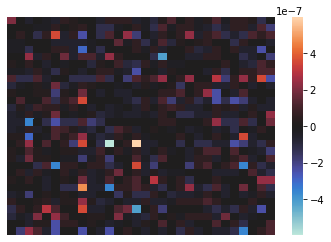

In [26]:
ax = sns.heatmap(K, center=0, xticklabels=False, yticklabels=False)
plt.show()

In [27]:
K = fill_diagonal(K, K.diagonal() + 1e-15)
samples = X.shape[0]
y = y.reshape(samples * 3)
alphas = np.linalg.solve(K, y)
alphas = alphas.reshape(10, 3)

In [28]:
def predict(x, samples=samples, X=X, alphas=alphas):
    mu = np.zeros(3)
    for i in range(samples):
        mu += kernel(x, X[i]) @ alphas[i]
    return mu

In [29]:
y = y.reshape(10, 3)
print(predict(X[9]))
print(y[9])

[ 0.04606384 -0.2893961  -0.5582838 ]
[ 0.04606372 -0.28939605 -0.5582838 ]


In [30]:
from utils import KRR

class VectorValuedKRR(KRR):

    def fit(self, X, y):
        self.X = X
        samples = X.shape[0]
        K = kernel_matrix(X)
        y = y.reshape(samples * 3)
        K = fill_diagonal(K, K.diagonal() + self.lamb)
        alphas = np.linalg.solve(K, y)
        self.alphas = alphas.reshape(samples, 3)

    def predict(self, x):
        results = [predict(_x, samples=self.samples, X=self.X, alphas=self.alphas) for _x in x]
        return np.array(results)

    def score(self, x, y):
        yhat = self.predict(x)
        return -np.mean(np.sum(np.abs(y - yhat), axis=1))


In [40]:
model = VectorValuedKRR()
model.fit(X[:50], y[:50])

In [42]:
print(model.predict([X[51]]))
print(y[51])

[[  2.0926805 -16.000454    9.09699  ]]
[-0.02243282  0.16857044  0.3250411 ]


In [44]:
model.score(X[:50], y[:50])

DeviceArray(-1.7730996e-05, dtype=float32)